In [1]:
from IPython.core.display import display, HTML
# Full display of notebook (width of screen)
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import basic libraries
import os, glob, sys
import numpy as np   
import pandas as pd 

# Define librearies needed for analysis
import matplotlib.pyplot as plt # Matplotlibrary
import seaborn as sns # Seaborn Library

from pylab import rcParams
rcParams['figure.figsize'] = 8, 8

feat_path = os.path.join(os.path.abspath(os.path.dirname(os.path.dirname(os.getcwd()))))
if feat_path not in sys.path:
    sys.path.append(feat_path)
    
%load_ext autoreload
%autoreload 2

np.random.seed(42)

# get additional tools
from src.utils import utils 

# Define path where data is located and folder to access to it
path_data = os.path.join(os.path.abspath(os.path.dirname(os.path.dirname(os.getcwd()))),'data','external')

In [2]:
# load data in pd dataframe
train = pd.read_csv(os.path.join(path_data,'train.csv'))
test = pd.read_csv(os.path.join(path_data,'test.csv'))

In [3]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
# Preliminary
# count NaN entries --> something to keep in mind
train.isnull().sum(axis = 0)

# comments
# **Age**, **Cabin** and **Embarked** have missing values --> remove or complete

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# 1. First check on features

## 1.1 Numerical

In [5]:
train.select_dtypes(include=[np.number]).info()

# comments
# within numerical features, only **Age** seems to be incomplete

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Age          714 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


### 1.1.1 PassengerId

In [6]:
len(np.unique(train['PassengerId']))

# comments
# unique index per passanger --> unless related to ticket, should be thrown away!

891

### 1.1.2 Survived

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


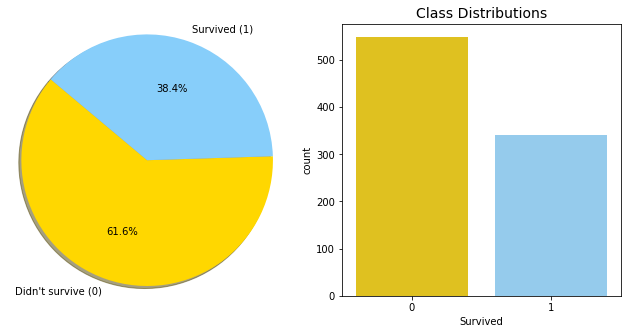

In [7]:
# feature: 'Survived' (Target: about the Survival of people, 0 = No, 1 = Yes)

f, axes = plt.subplots(1, 2,figsize=(11,5))

surv_dic  = {0: """Didn't survive (0)""", 1: """Survived (1)""" }
sizes  = train["Survived"].value_counts().values
labels = [surv_dic[i] for i in train["Survived"].value_counts().index.tolist() ]

colors = ['gold', 'lightskyblue', 'yellowgreen', 'lightcoral']

# Plot
axes[0].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
axes[0].axis('equal')

sns.countplot('Survived', data=train, palette=colors, ax=axes[1])

plt.title('Class Distributions', fontsize=14)
plt.show()

# commnets:
# majority of people death

### 1.1.3 Pclass

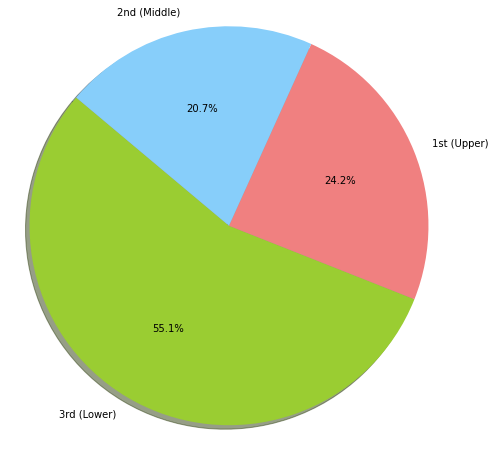

In [8]:
# feature: 'Pclass' (about the Ticket class, a proxy for socio-economic status (SES))
pclass_dic  = {1: "1st (Upper)", 2: "2nd (Middle)", 3: "3rd (Lower)" }
sizes  = train["Pclass"].value_counts().values
labels = [pclass_dic[i] for i in train["Pclass"].value_counts().index.tolist() ]
colors = ['yellowgreen', 'lightcoral', 'lightskyblue', 'gold' ]

# Plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

# commnets:
# majority of people comes from 3rd class

In [9]:
train[["Pclass", "Survived"]].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# commnets:
# survival in the first class is much higher than in lower classes!!

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


### 1.1.4 Age

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

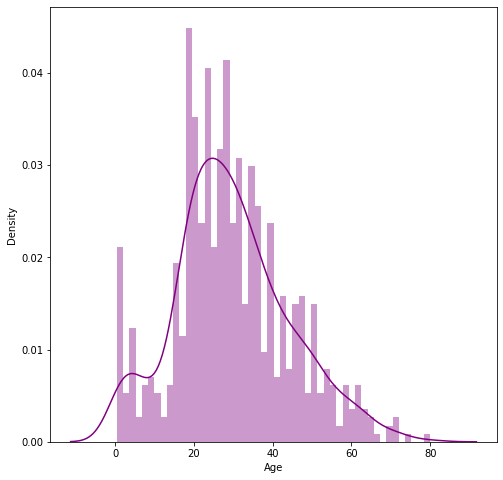

In [10]:
# feature: 'Age' (Age in years, age is fractional if less than 1. 
#                 If the age is estimated, is it in the form of xx.5)
sns.distplot(train["Age"], bins=50, color="purple")

# commnets:
# 177 missing values
# may be useful to try to relate ages with titles!!

### 1.1.5 SibSp and Parch, FamilySize

In [11]:
# feature: 'SibSp' (# of siblings / spouses aboard the Titanic)
# Sibling = brother, sister, stepbrother, stepsister
# Spouse = husband, wife (mistresses and fiancés were ignored)

# feature: 'Parch' (# of parents / children aboard the Titanic) 
# The dataset defines family relations in this way:
# Parent = mother, father
# Child = daughter, son, stepdaughter, stepson
# Some children travelled only with a nanny, therefore parch=0 for them

# get Size family
train = utils.get_size_family(train)

In [12]:
train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

,FamilySize,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.136364
6,7,0.333333
7,8,0.000000
8,11,0.000000


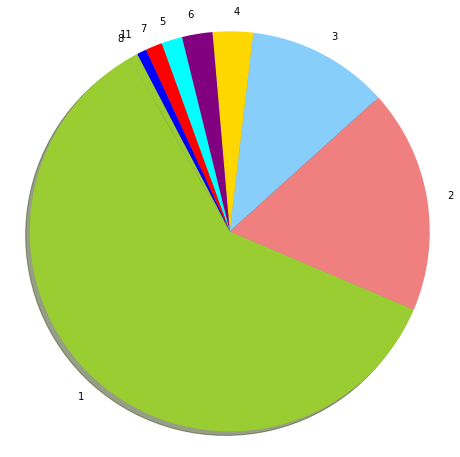

In [13]:
sizes   = train["FamilySize"].value_counts().values
labels  = train["FamilySize"].value_counts().index.tolist()
colors  = ['yellowgreen', 'lightcoral', 'lightskyblue', 'gold', 'purple', 'cyan', 'red', 'blue' ]
#explode = (0.1, 0, 0, 0, 0, 0.15, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
# Plot
plt.pie(sizes, labels=labels, colors=colors,  #autopct='%1.1f%%', 
        shadow=True, startangle=120)
plt.axis('equal')
plt.show()

# commnets:
# majority of people were alone

### 1.1.6 Fare

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Fare', ylabel='Density'>

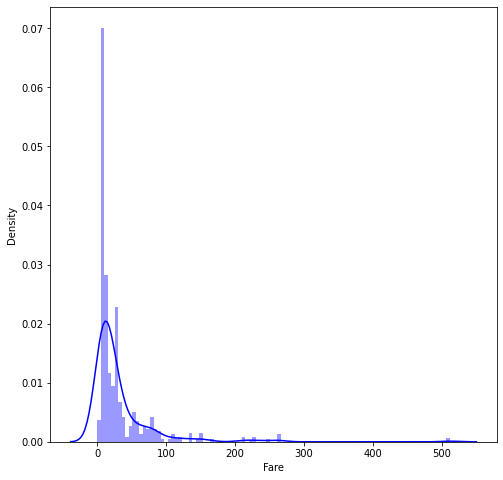

In [14]:
# feature: 'Fare' (Passenger fare)
sns.distplot(train["Fare"], bins=100, color="blue")

# commnets:
# only minority of farea are above 200 dollars 
# --> may consider stratification and investigate if the fare is from
# a full family
# needs to be change to intervals

In [15]:
# produce intervals
train = utils.modify_fare(train)

# inspect
train[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean()

,Fare,Survived
0,0,0.197309
1,1,0.308756
2,2,0.445415
3,3,0.581081


## 1.2 Categorical

In [16]:
train.select_dtypes(exclude=[np.number]).info()

# comments
# **Cabin** seems to be incomplete
# **Embarked** seems to have 2 missing entries

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Name      891 non-null    object
 1   Sex       891 non-null    object
 2   Ticket    891 non-null    object
 3   Cabin     204 non-null    object
 4   Embarked  889 non-null    object
dtypes: object(5)
memory usage: 34.9+ KB


In [17]:
train.select_dtypes(exclude=[np.number]).keys()

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

### 1.2.1 Name, Title

In [18]:
# feature: 'Name' 
train['Name'][:5]

# commnets:
# unique titles: Mr. Mrs. Miss. Don. Master. Rev. Mme. Dr. Col. Capt. Countess. Lady. Dona. Major. Mlle. Mme.
#   --> use to proxy family/status?
# e.g. Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg) --> proxy for married people, siblings ?

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [19]:
# 'Mrs', 'Mr', 'Master', 'Dr'
# 'Miss' = is a title used generally by unmarried women
# 'Don'= derived from the Latin Dominus; it means a master of a household. It is an honorific prefix primarily used in Italy, Spain, Portugal, Latin America, Croatia, Goa, and the Philippines
# 'Mme' = short for Madame (French for, Madam)
# 'Ms' =  is a title used by women regardless of their marital status
# 'Major' = is a mil**itary rank of commissioned officer status
# 'Col' = Colonel is conferred by some states in the United States of America
# 'Jonkheer' = is [](http://)a male honorific for Dutch nobility
# 'Mlle' = Mademoiselle is a French courtesy title, abbreviated Mlle, traditionally given to an unmarried woman 
# 'Rev' = Reverend (placed before the names of Christian clergy and ministers)
# 'Capt' = Captain
# 'Countess' =  is a historical title of nobility in certain European countries

In [20]:
  # e.g.
print("""Full testing name for function: '{}' """.format(train['Name'][0]))
print("""Definition used leads to: '{}' """.format(utils.get_title(train['Name'][0])))

Full testing name for function: 'Braund, Mr. Owen Harris' 
Definition used leads to: 'Mr' 


In [21]:
# Create a new feature Title, containing the titles of passenger names
train = utils.get_titles(train, True)

In [22]:
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [23]:
# Add missing ages
train = utils.get_new_ages(train)

In [24]:
# Simplify categories titles
train = utils.modify_titles(train)

# inspect reduced version
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Master,0,40
Miss,185,0
Mr,0,517
Mrs,126,0
Rare,3,20


In [25]:
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


### 1.2.2 Sex

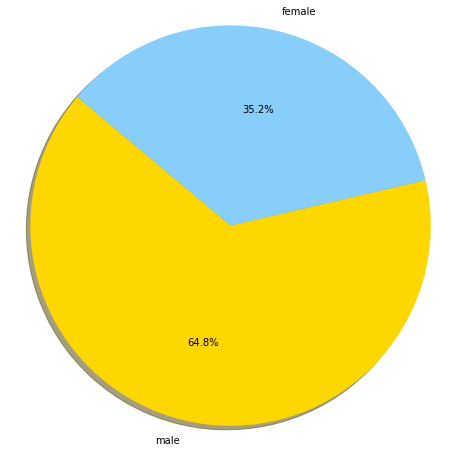

In [26]:
# feature: 'Sex' 
sizes  = train["Sex"].value_counts().values
labels = train["Sex"].value_counts().index.tolist()
colors = ['gold', 'lightskyblue', 'yellowgreen', 'lightcoral']

# Plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

# comments
# imbalance in terms of gender 

In [27]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


### 1.2.3 Ticket

In [28]:
# feature: 'Ticket' (Ticket number)
train["Ticket"].value_counts().index.tolist()[:4]

# comments
# indices seem to be both numbers, strings (maybe related to class),
# and a combination of both
# --> could be used to identify groups/families
# ISSUE: splitting of data may separate families, results may be bias
## --> sol: Hashing or jaro distances may be a good way to overcome this issue

['347082', '1601', 'CA. 2343', '347088']

In [29]:
train["Ticket"].value_counts()

347082           7
1601             7
CA. 2343         7
347088           6
CA 2144          6
                ..
347085           1
367231           1
343275           1
SC/PARIS 2167    1
2677             1
Name: Ticket, Length: 681, dtype: int64

### 1.2.4 Cabin

In [30]:
# feature: 'Cabin' (Cabin number)
train["Cabin"].value_counts().index.tolist()[:5]

# comments
# indices seem to contain information about location of cabins with respect 
# to ship layout 
# --> investigate and correlate location with a likelihood of survival:
# i.e. Most likely, people located in upper levels and closer to boats may
# have a better chance to have survived?

['B96 B98', 'G6', 'C23 C25 C27', 'D', 'C22 C26']

In [31]:
# e.g.
print("""Full testing name for function: '{}' """.format(train['Cabin'][3]))
print("""Definition used leads to: '{}' """.format(utils.get_deck(train['Cabin'][3])))
# or 
print("")
# e.g.
print("""Full testing name for function: '{}' """.format(train['Cabin'][8]))
print("""Definition used leads to: '{}' """.format(utils.get_deck(train['Cabin'][8])))

Full testing name for function: 'C123' 
Definition used leads to: 'C' 

Full testing name for function: 'nan' 
Definition used leads to: 'None' 


In [32]:
# Create a new feature Title, containing the titles of passenger names
train = utils.get_decks(train)
train[['Deck', 'Survived']].groupby(['Deck'], as_index=False).mean()

,Deck,Survived
0,A,0.466667
1,B,0.744681
2,C,0.593220
3,D,0.757576
4,E,0.750000
5,F,0.615385
6,G,0.500000
7,None,0.299419


### 1.2.5 Embarked

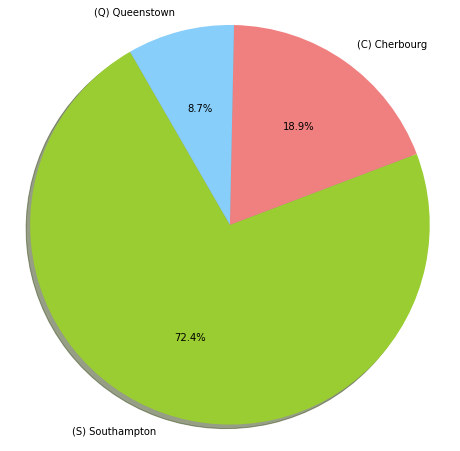

In [33]:
# feature: 'Embarked' (Port of Embarkation)
# C = Cherbourg, Q = Queenstown, S = Southampton
embk_dic  = {'C': "(C) Cherbourg", 'Q': "(Q) Queenstown", 'S': "(S) Southampton" }
sizes  = train["Embarked"].value_counts().values
labels = [embk_dic[i] for i in train["Embarked"].value_counts().index.tolist() ]
colors  = ['yellowgreen', 'lightcoral', 'lightskyblue', 'gold', 'purple', 'cyan', 'red' ]
# Plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
        shadow=True, startangle=120)
plt.axis('equal')
plt.show()

# commnets:
# majority of people departed from Southampton --> is there any relation with class? 

In [34]:
train[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [35]:
# Missing values
train[train['Embarked'].isnull() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title,Deck
61,62,1,1,"Icard, Miss. Amelie",female,Adult,0,0,113572,3,B28,NaN,1,Miss,B
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,Senior,0,0,113572,3,B28,NaN,1,Mrs,B


In [36]:
# Relate Embarked and Pclass
train.groupby(["Embarked", "Pclass"]).size()

Embarked  Pclass
C         1          85
          2          17
          3          66
Q         1           2
          2           3
          3          72
S         1         127
          2         164
          3         353
dtype: int64

In [37]:
# get missing Embarked
train = utils.get_embarked_bayes(train)

### 2. Transform categorical to numerical

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int64   
 1   Survived     891 non-null    int64   
 2   Pclass       891 non-null    int64   
 3   Name         891 non-null    object  
 4   Sex          891 non-null    object  
 5   Age          891 non-null    category
 6   SibSp        891 non-null    int64   
 7   Parch        891 non-null    int64   
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    int64   
 10  Cabin        204 non-null    object  
 11  Embarked     891 non-null    object  
 12  FamilySize   891 non-null    int64   
 13  Title        891 non-null    object  
 14  Deck         891 non-null    object  
dtypes: category(1), int64(7), object(7)
memory usage: 98.6+ KB


In [39]:
np.unique(train['Sex'])

array(['female', 'male'], dtype=object)

In [40]:
# Modify dataframe
train = utils.transform_cat_to_num(train)

In [41]:
to_drop = ['PassengerId','SibSp','Parch', 'Ticket', 'Cabin' ,'Name']

# remove no longer useful features
train = utils.drop_features(train, to_drop)

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Survived    891 non-null    int64
 1   Pclass      891 non-null    int64
 2   Sex         891 non-null    int64
 3   Age         891 non-null    int64
 4   Fare        891 non-null    int64
 5   Embarked    891 non-null    int64
 6   FamilySize  891 non-null    int64
 7   Title       891 non-null    int64
 8   Deck        891 non-null    int64
dtypes: int64(9)
memory usage: 62.8 KB


In [43]:
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title,Deck
0,0,3,0,1,0,0,2,2,7
1,1,1,1,2,3,1,2,3,2
2,1,3,1,1,1,0,1,1,7
3,1,1,1,2,3,0,2,3,2
4,0,3,0,2,1,0,1,2,7


# 3. Correlations

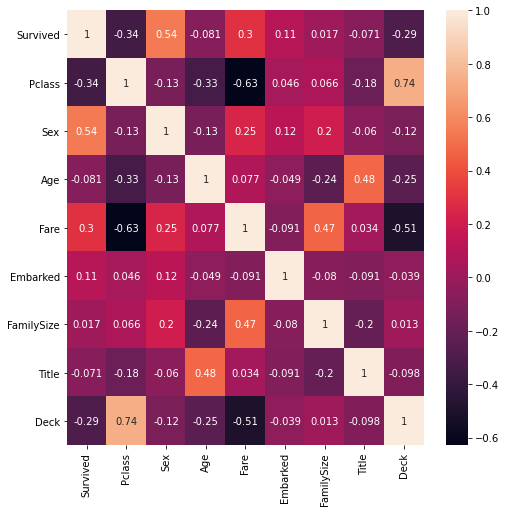

In [44]:
# ref: https://likegeeks.com/python-correlation-matrix/
correlation_mat = train.corr() # Compute Pearson’s correlation coefficient

# ** A large positive value (near to 1.0) indicates a strong positive correlation, i.e., if the value of 
# one of the variables increases, the value of the other variable increases as well
# ** A large negative value (near to -1.0) indicates a strong negative correlation, i.e., the value of one 
# variable decreases with the other’s increasing and vice-versa
# ** A value near to 0 (both positive or negative) indicates the absence of any correlation 
# between the two variables, and hence those variables are independent of each other

sns.heatmap(correlation_mat, annot = True)

plt.show()

# coments
# Pclass and Fare seems to be slightly anti-correlated
# Sex and survival are quite correlated

# 4. Pipeline

In [45]:
to_drop = ['PassengerId','SibSp','Parch', 'Ticket', 'Cabin' ,'Name']

test = utils.pipeline_features(test, to_drop)
test.head(5)

,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title,Deck
0,3,0,2,0,2,1,2,7
1,3,1,2,0,0,2,3,7
2,2,0,3,1,2,1,2,7
3,3,0,1,1,0,1,2,7
4,3,1,1,1,0,3,3,7
